<a href="https://colab.research.google.com/github/ZacharySBrown/vcu-scma440-2021q1/blob/master/examples/4a_averages_and_ses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Fetch Data
Press the play button in Google Colab or press Shift+Enter execute the cell below to download and load the data and packages for this assignment

This will load four pandas DataFrame objects: shampoo,housing, airline, and airline_series. Each of these is used in Makridakis Chapter 3.

In [156]:
import pandas as pd
from numpy import log, abs, mean, exp
from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16



!curl https://raw.githubusercontent.com/ZacharySBrown/vcu-scma440-2021q1/master/utils/fetch_e4.sh > fetch_e4.sh
!bash fetch_e4.sh

# Example
shampoo = pd.read_csv('shampoo_sales.csv', parse_dates=['date']).set_index('date')
housing = pd.read_csv('housing_sales.csv', parse_dates=['date']).set_index('date')
airline = pd.read_csv('airline.csv').set_index('year')
airline_series = pd.read_csv('airline_series.csv', parse_dates=['date']).set_index('date')
can_openers = pd.read_csv('can_openers.csv', parse_dates=['month']).set_index('month')

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   477  100   477    0     0   3785      0 --:--:-- --:--:-- --:--:--  3785
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   629  100   629    0     0   4952      0 --:--:-- --:--:-- --:--:--  4992
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3867  100  3867    0     0  37182      0 --:--:-- --:--:-- --:--:-- 37182
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   456  100   456    0     0   3931      0 --:--:-- --:--:-- --:--:--  3931
  % Total    % Received % Xferd  Average Speed   Tim

# Insepcting the Data

Let's first start by taking a look at the can opener shipments data

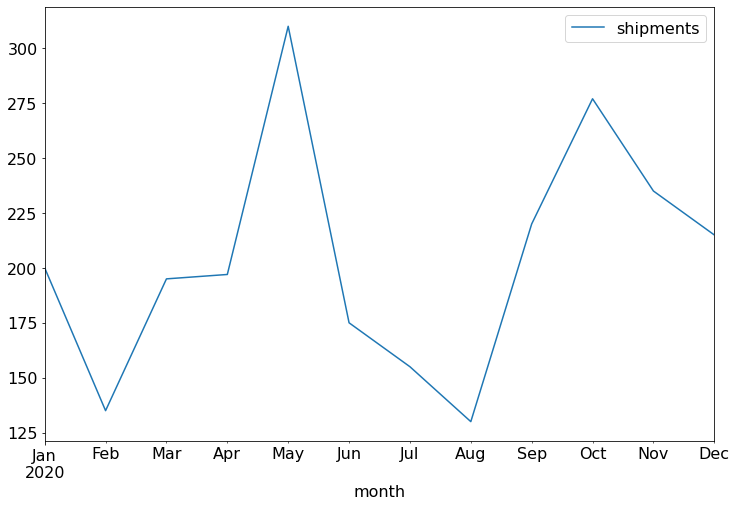

In [5]:
can_openers.plot()

# Running Average as a Forecast

This data looks like it may be reasonably stationary (at least on this time scale), so let's begin with a simple running mean forecast. We can do this with the `.expanding()`. The `expanding()` is similar to the `rolling()` function in that it creates a window over which statistics can be calculated. The difference is that `.expanding()` does not use a fixed length window, but rather a variable length window that includes the current and all _previous_ observations. 

Note that the `.expanding()` function computes the running average for all observations up through and including the current observation. Recall that the forecast for time step `t+1` is the running average up through time step `t`, so to ensure that the forecast is aligned with the correct time step, we'll need to adjust the running mean calculated with `.expanding()` ahead by one timestep, so that the running mean up through timestep `t` will be the _forecast_ value for time step `t+1`

See the code below to calculate and plot this:

In [6]:
can_openers['mean_forecast'] = can_openers.expanding().mean().shift(1)
can_openers.head()

,shipments,mean_forecast
month,,
2020-01-01,200,NaN
2020-02-01,135,200.000000
2020-03-01,195,167.500000
2020-04-01,197,176.666667
2020-05-01,310,181.750000


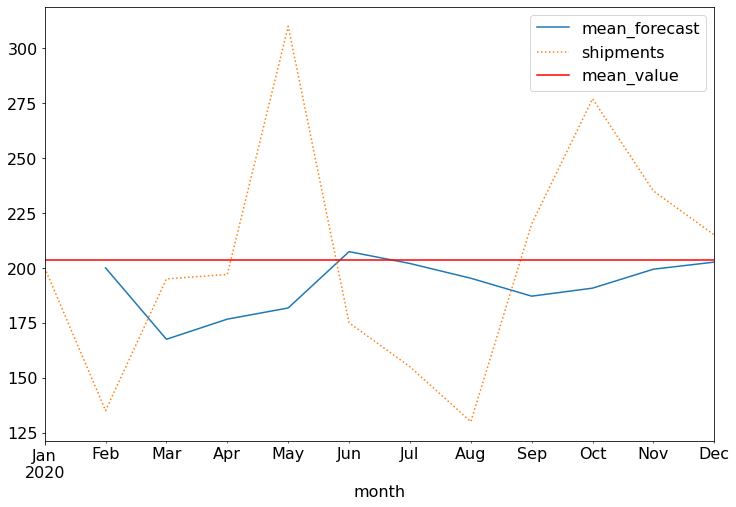

In [9]:
can_openers['mean_forecast'].plot()

can_openers['mean_value'] = can_openers['shipments'].mean()

ax = plt.gca()
can_openers['shipments'].plot(linestyle='dotted', ax=ax)
can_openers['mean_value'].plot(color='red', ax=ax)
plt.legend()

If this data is truly non-seasonal (the observed spikes are _random_ across years), then this running average _could_ provide a reasonable baseline estimate forecast. 

# **MA(k)** Forecasts

A slightly more robust approach would be to create an **MA(k)** forecast, using a rolling window of length (k). This would allow the forecast to adjust to a new mean value over a small set of (k) observations to correct for things like step changes. 

An **MA(k)** _forcast_ is computed using the `.rolling()` function just as we used before, however the resulting values need to be shifted forward appropriately, with the amount depending on the size of the time window. 

For an **MA(k)** forecast, the centered average needs to be shifted foreward by `(k+1)/2` time steps to move from the _center_ of the window to one time step _ahead_ of the window. E.g., for an **MA(3)** forecast, you would shift a **3MA** (centered) smoother forward by `(3+1)/2 = 2` time steps. For an **MA(7)** forecast, you'd move a **3MA** (centered) smoother forward by `(7+1)/2 = 4` time steps. 

See below for an example calculation.

In [44]:
can_openers = pd.read_csv('can_openers.csv', parse_dates=['month']).set_index('month')
#can_openers['3MA_smoother'] = can_openers['shipments'].rolling(3, center=True).mean()
#can_openers['5MA_smoother'] = can_openers['shipments'].rolling(5, center=True).mean()
can_openers['MA3_forecast'] = can_openers['shipments'].rolling(3, center=True).mean().shift()
can_openers['MA5_forecast'] = can_openers['shipments'].rolling(5, center=True).mean().shift(3)
can_openers.head(10)

,shipments,MA3_forecast,MA5_forecast
month,,,
2020-01-01,200,NaN,NaN
2020-02-01,135,NaN,NaN
2020-03-01,195,176.666667,NaN
2020-04-01,197,175.666667,NaN
2020-05-01,310,234.000000,NaN
2020-06-01,175,227.333333,207.4
2020-07-01,155,213.333333,202.4
2020-08-01,130,153.333333,206.4
2020-09-01,220,168.333333,193.4


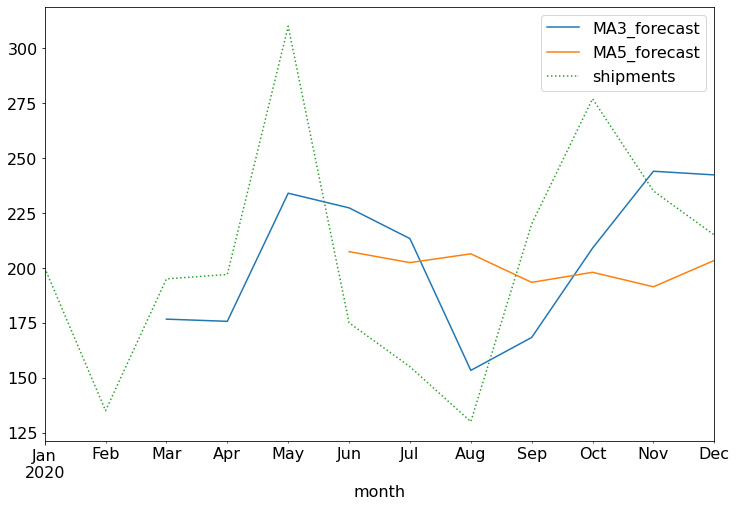

In [45]:
can_openers['MA3_forecast'].plot()
can_openers['MA5_forecast'].plot()
ax = plt.gca()
can_openers['shipments'].plot(linestyle='dotted', ax=ax)

plt.legend()

# Single Exponential Smoothing

For single exponential smoothing, we'll use `SimpleExpSmoothing` from the `statsmodels.tsa`. `SimpleExpSMoothing` can be appplied with the following syntax:

```
initial_level = data['column'][0]

smoother = SimpleExpSmoothing(data['column'])
results = smoother.fit(smoothing_level=0.1, initial_level=initial_level)
```

Here, the `smoothing_level` is the value of `alpha` for the smoother, and the `intitial_level` is the intial forecast level. 



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:720: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  warn(message, EstimationWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:720: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  warn(message, EstimationWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:720: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  warn(message, EstimationWarning)


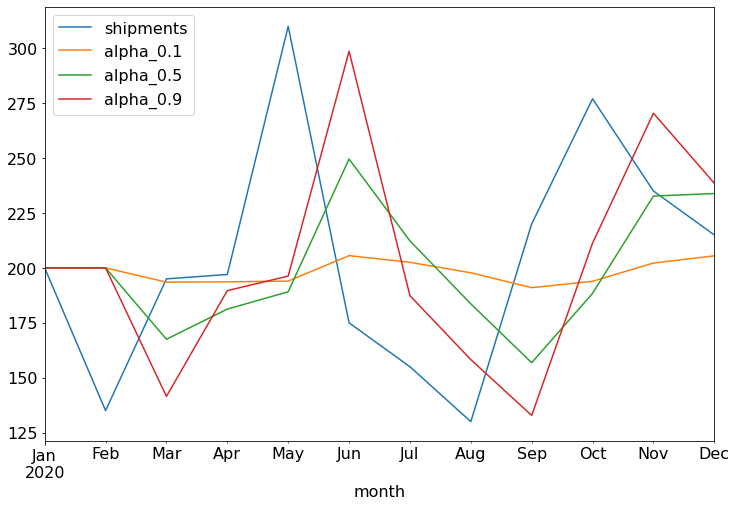

In [160]:
# Reload a fresh copy of our data
can_openers = pd.read_csv('can_openers.csv', parse_dates=['month']).set_index('month')

initial_level = can_openers['shipments'][0]

smoother = SimpleExpSmoothing(can_openers['shipments'])
results_1 = smoother.fit(smoothing_level=0.1, initial_level=initial_level)
results_5 = smoother.fit(smoothing_level=0.5, initial_level=initial_level)
results_9 = smoother.fit(smoothing_level=0.9, initial_level=initial_level)
can_openers['alpha_0.1'] = results_1.fittedvalues
can_openers['alpha_0.5'] = results_5.fittedvalues
can_openers['alpha_0.9'] = results_9.fittedvalues

can_openers.plot()

For small values of the smoothing parameter, we expect weights to fall off very slowly, so choice of initial forecast becomes a larger factor. We can take a look at several choices for initializing the forecast using averages of the first few observations

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:720: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  warn(message, EstimationWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:720: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  warn(message, EstimationWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:720: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  warn(message, EstimationWarning)


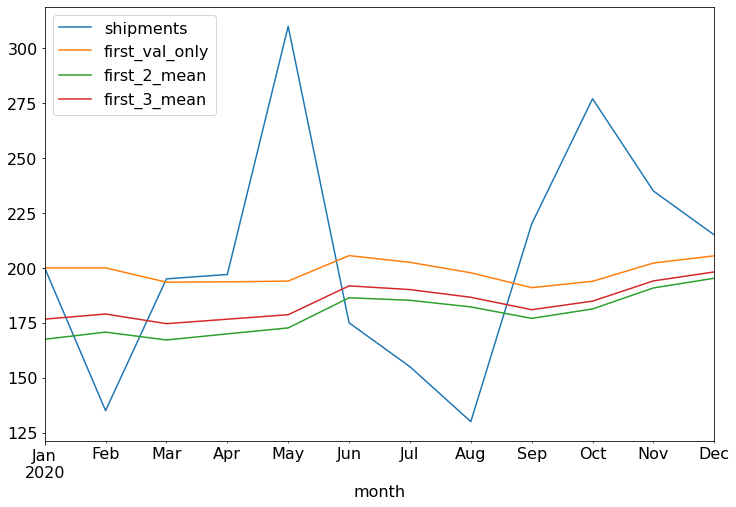

In [161]:
# Reload a fresh copy of our data
can_openers = pd.read_csv('can_openers.csv', parse_dates=['month']).set_index('month')

initial_level_1 = can_openers['shipments'][0]
initial_level_2 = can_openers['shipments'][0:2].mean()
initial_level_3 = can_openers['shipments'][0:3].mean()

smoother = SimpleExpSmoothing(can_openers['shipments'])
results_1 = smoother.fit(smoothing_level=0.1, initial_level=initial_level_1)
results_2 = smoother.fit(smoothing_level=0.1, initial_level=initial_level_2)
results_3 = smoother.fit(smoothing_level=0.1, initial_level=initial_level_3)
can_openers['first_val_only'] = results_1.fittedvalues
can_openers['first_2_mean'] = results_2.fittedvalues
can_openers['first_3_mean'] = results_3.fittedvalues

can_openers.plot()